# Data Mining and Statistics
## Session 6 - Clustering
*Peter Stikker - Haarlem, the Netherlands*

----

Our basic libraries...

In [11]:
#!pip install numpy
import numpy as np

#!pip install pandas
import pandas as pd

#!pip install matplotlib
from matplotlib import pyplot as plt

## 6.1. A Centroid Method: K-means

Lets load some customer data:

In [12]:
# load data as panda data frame
custdf = pd.read_csv('../data/Mall_Customers.csv')
# rename some of the longer field names
custdf=custdf.rename(columns={"Annual Income (k$)":"income", "Spending Score (1-100)":"spendingScore"})
# show first 5 records
custdf.head()

,CustomerID,Gender,Age,income,spendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Now we want to cluster our customers based on their income and spendingScore

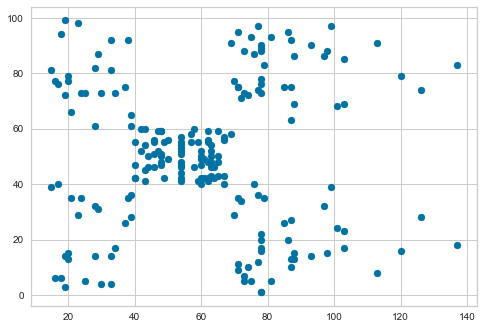

In [13]:
# Set the two variables as X
custX =custdf[["income", "spendingScore"]]

# Remove missing values
custX=custX.dropna()

# Visualise data
plt.scatter(custX["income"],custX["spendingScore"]);

From the data, I'd suspect 5 clusters (similar as 5 is shown on a die). 

We'll need the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">**KMeans()**</a> function package from <a href="https://scikit-learn.org/stable/">*sklearn*</a>:

In [14]:
#!pip install sklearn
from sklearn.cluster import KMeans

The function requires:
* *init*: the $k$ initial points, to be used as the 'starting' point for clusters. We can just set this to 'random'.
* *algorithm*: which specific version of k-means to use. The full method is named 'lloyd', but we'll see other versions later
* *n_cluster*: our $k$ value, i.e. how many clusters do we want.
* *random_state*: since we let sklearn decide on which points to use as starting point, and we perhaps want to all have the same result, we can set this so we all should have the same result

We can then fit the 'model' and make a nice scatterplot from it:

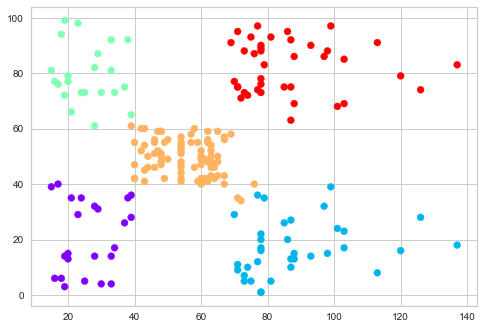

In [15]:
kmeans = KMeans(init='random', algorithm='full', n_clusters=5, random_state=0)
kmeans.fit(custX)
plt.scatter(custX["income"],custX["spendingScore"], c=kmeans.labels_, cmap='rainbow')

We get a warning: *"_kmeans.py:1040: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1."*. 

You could avoid this error by doing as is suggested:
```python
import os
os.environ["OMP_NUM_THREADS"] = "1" 
```

However, you will need to do this BEFORE you import numpy.

Alternatively, to simply avoid seeing this warning every time we run into it, we can use the *warnings* library and set it to ignore warnings with the last text shown from our warning: "KMeans is known to have a memory leak on Windows ".

In [16]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows ")

# check no warning...
kmeans = KMeans(init='random', algorithm='full', n_clusters=5, random_state=0)

Now, for every future warning with the same message it will not appear. 

Was 5 indeed a good number of clusters? Looks good, but lets see what our metrics might have to say about it.

<a href="https://www.scikit-yb.org/">*Yellowbrick*</a> (a library that combines sklearn and pyplot) has a nice <a href="https://www.scikit-yb.org/en/latest/api/cluster/elbow.html">**KElbowVisualizer()**</a> function that can be used. First install it using 'pip install yellowbrick', then load the library

In [17]:
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Now we can visualise the results. I'll make a small function out of this, so it can be used a few times.

The KElbowVisualizer has the following parameters:
* *estimator*: the model that we fitted
* *k*: a range of values for the number of clusters (k) to check
* *metric*: which measure to use to determine how good the clustering is

In [18]:
def elbowPlot(data, model, kRange):

    # set the plotting stage for later
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, constrained_layout=True,figsize=(15,5))

    # Using the Distortion measure:
    visualizer = KElbowVisualizer(model, k=kRange, metric='distortion', ax=ax1)
    chPlot=visualizer.fit(data)
    ax1.set_title('Distortion')

    # Using the Calinski-Harabasz measure
    visualizer = KElbowVisualizer(model, k=kRange, metric='calinski_harabasz', ax=ax2)
    chPlot=visualizer.fit(data)
    ax2.set_title('Calinski-Harabasz')

    # Using the Silhouette measure
    visualizer = KElbowVisualizer(model, k=kRange, metric='silhouette', ax=ax3)
    chPlot=visualizer.fit(data)
    ax3.set_title('Silhouette')

    # Show the results
    plt.show()

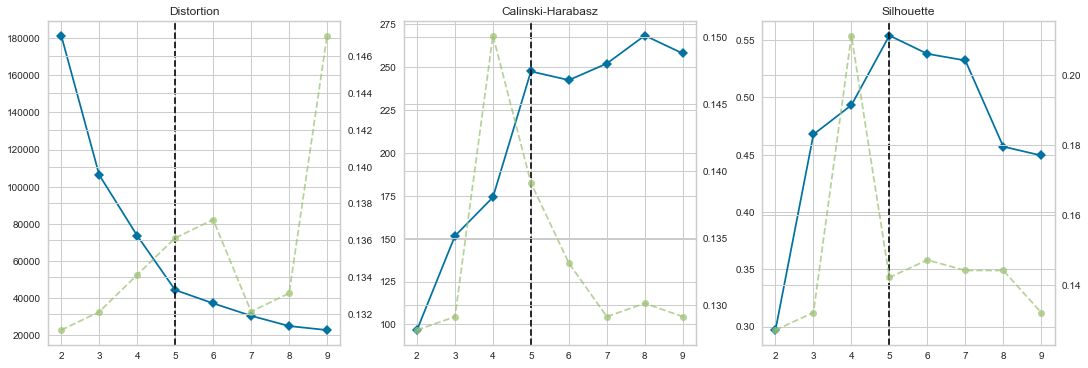

In [19]:
elbowPlot(custX, kmeans, (2,10))

All three measures are in agreement. The k=5 was a good choice.

Note that the default settings of sklearns kmeans is actually a k-means++ with Elkan's algorithm.

In [22]:
%%timeit
# our original k-means Lloyd version
kmeans = KMeans(init='random', algorithm='full', n_clusters=5, random_state=0)
kmeans.fit(custX)

128 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit
# our k-means with Elkan's algorithm
kmeans = KMeans(init='random', algorithm='elkan', n_clusters=5, random_state=0)
kmeans.fit(custX)

12.9 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
# k-means++ with Elkan's algorithm
kmeans = KMeans(init='k-means++',algorithm='elkan', n_clusters=5, random_state=0)
kmeans.fit(custX)

19.1 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As can be seen the Elkan algorithm is indeed much faster. For the small data size the k-means++ is actually slower, but this should change with bigger data sets.

In Appendix A1 the Python code for some other centroid based methods (Affinity Propagation, Spectral Clustering, Mini Batch K-means, and k-Medoids) is shown.

k-means tries to find 'center' points for clusters. So a cluster for k-means is a bunch of datapoints that have the smallest distance to that center. So indeed this works well, if clusters are around a center, and these centers are not too close to each other. In real life, often this is not the case.

Lets have a look at a clear example where this is not the case. The dataset is one that comes with the library *sklearn*:

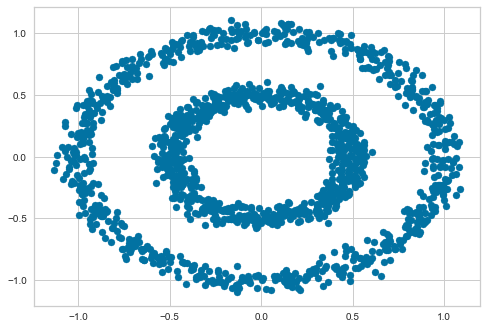

In [25]:
from sklearn import datasets
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
circX=noisy_circles[0]
plt.scatter(circX[:,0],circX[:,1]);

Now lets see how well k-means performs with this data.

I'm expecting two clusters (the inner-circle, and the outer-circle), so will use k = 2:

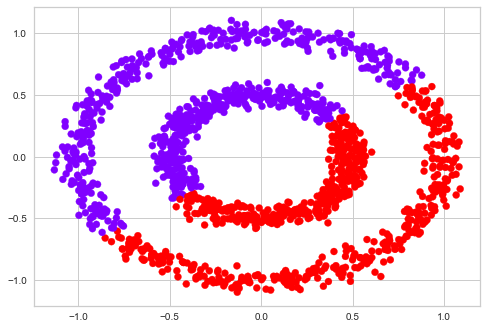

In [26]:
kmeans = KMeans(init='random', algorithm='full', n_clusters=2, random_state=0)
kmeans.fit(circX)
plt.scatter(circX[:,0],circX[:,1], c=kmeans.labels_, cmap='rainbow');

Ai, that doesn't look good. Perhaps use more clusters? Lets see what our elbow plots say...

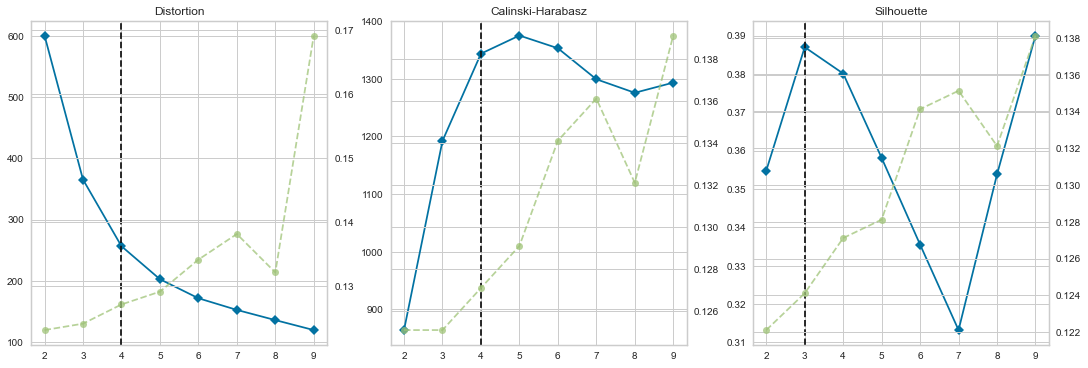

In [27]:
elbowPlot(circX, kmeans, (2,10))

Two of them suggest 4, and one suggests 3. Lets try 4:

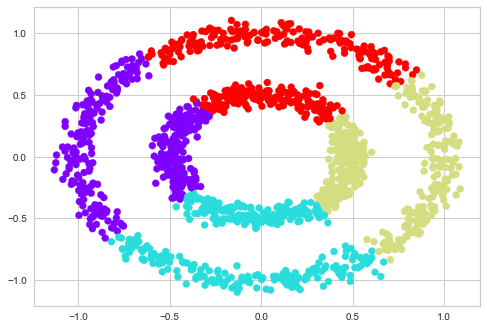

In [28]:
kmeans = KMeans(init='random', algorithm='full', n_clusters=4, random_state=0)
kmeans.fit(circX)
plt.scatter(circX[:,0],circX[:,1], c=kmeans.labels_, cmap='rainbow');

Ah well. As expected a centroid method is perhaps not the best approach here. Hopefully our next approach does better.

**Exercise 1**

**Exercise 1a.**

Load the Soccer2019C.csv data and then create a scatter plot of "Finishing" and "HeadingAccuracy"

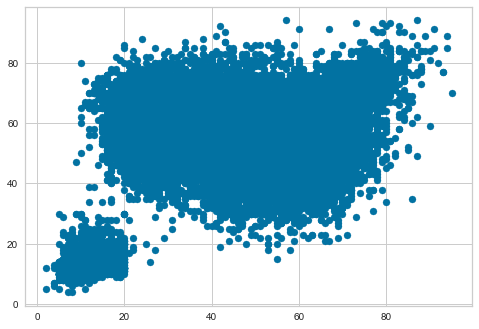

In [29]:
# your code here...
footbal_df = pd.read_csv('../data/Soccer2019C.csv')

Xs = footbal_df[['Finishing', 'HeadingAccuracy']].dropna()

plt.scatter(Xs['Finishing'], Xs['HeadingAccuracy'])

**Exercise 1.2.**

How many clusters would you suspect there to be, just by visual inspection? <br>

huhuhuh I guess 2 lmao

*Type your answer here...*

**Exercise 1.3.**

Check if the elbow plots match your suspicion

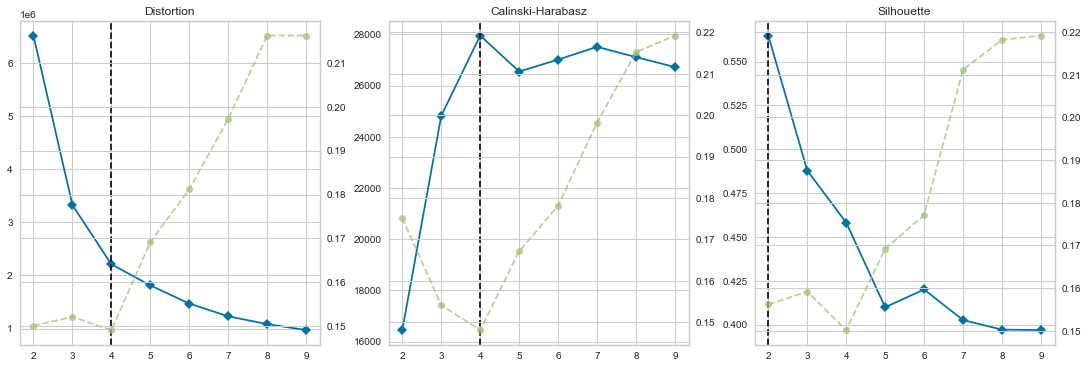

In [30]:
# Your code here....'
kmeans = KMeans(init='random', algorithm='full', n_clusters=2, random_state=0)
kmeans.fit(Xs)

elbowPlot(Xs, kmeans, (2,10))

**Exercise 1.4.**

Create a scatter plot with the number of clusters

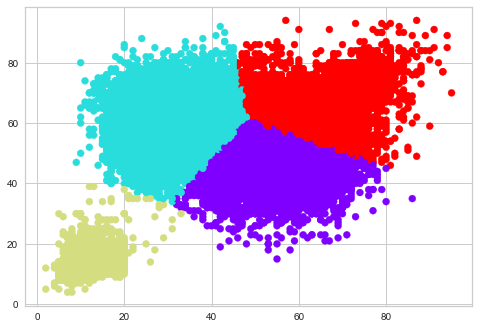

In [31]:
# your answer here...
kmeans = KMeans(init='random', algorithm='full', n_clusters=4, random_state=0)
kmeans.fit(Xs)
plt.scatter(Xs["Finishing"],Xs["HeadingAccuracy"], c=kmeans.labels_, cmap='rainbow')

<font size="8"><center>Back to the slides</center></font>

## 6.2. Hierarchical Clustering

The previous section ended with an example where k-means clustering just doesn't seem to work. Perhaps hierarchical clustering can do better. Sklearn has us covered for this with a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html">**AgglomerativeClustering()**</a> function.

In [32]:
from sklearn.cluster import AgglomerativeClustering

This works similar again. It has as parameters:
* *linkage*: which linkage we want to use
* *n_clusters*: the number of clusters we want

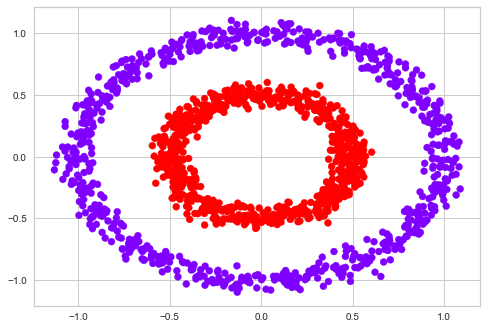

In [33]:
hierClust = AgglomerativeClustering(linkage='single', n_clusters=2)
hierClust.fit(circX)
plt.scatter(circX[:,0],circX[:,1], c=hierClust.labels_, cmap='rainbow')

Perfect, but....The linkage chosen here was 'single'. How would the other linkage methods perform?

I'll make this comparison again later, with a different dataset, so make a small temporary function for it:

In [34]:
# this function takes a numpy array as input, and the number of clusters.

def compareLinkage(myData, k):
    hca, axs = plt.subplots(2,2, constrained_layout=True)

    hierClust = AgglomerativeClustering(linkage='single', n_clusters=k)
    hierClust.fit(myData)
    axs[0,0].scatter(myData[:,0],myData[:,1], c=hierClust.labels_, cmap='rainbow')
    axs[0,0].set_title('Single')

    hierClust = AgglomerativeClustering(linkage='average', n_clusters=k)
    hierClust.fit(myData)
    axs[0,1].scatter(myData[:,0],myData[:,1], c=hierClust.labels_, cmap='rainbow')
    axs[0,1].set_title('Average')

    hierClust = AgglomerativeClustering(linkage='complete', n_clusters=k)
    hierClust.fit(myData)
    axs[1,0].scatter(myData[:,0],myData[:,1], c=hierClust.labels_, cmap='rainbow')
    axs[1,0].set_title('Complete')

    hierClust = AgglomerativeClustering(linkage='ward', n_clusters=k)
    hierClust.fit(myData)
    axs[1,1].scatter(myData[:,0],myData[:,1], c=hierClust.labels_, cmap='rainbow')
    axs[1,1].set_title('Ward')

    plt.show()

In [54]:
circX

array([[ 0.54970992,  0.71528805],
       [ 1.0472342 , -0.04529707],
       [ 0.12224123,  0.99190889],
       ...,
       [ 0.31803962,  0.92808098],
       [ 0.23533325, -0.37427715],
       [-0.38228607, -0.25199899]])

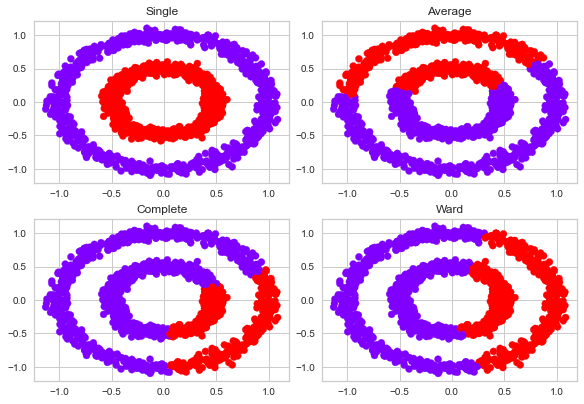

In [35]:
compareLinkage(circX, 2)

Ai, it appears that the single-linkage method, is the only one that does it properly...on this data set!

How would it look in our customer data set?

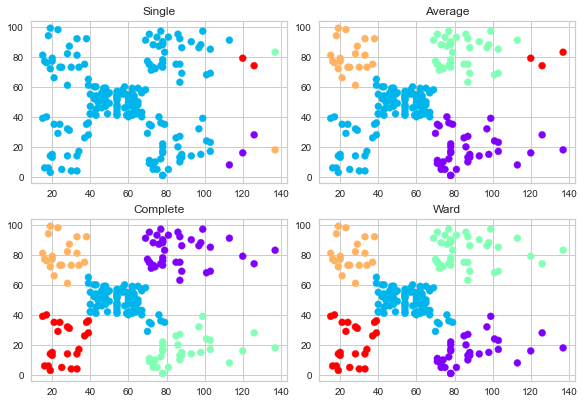

In [36]:
compareLinkage(np.asarray(custX), 5)

In this case the single appears to be the worst. 

The reason why single-linkage performs so different is that it is a density based method, while the others are more centroid based. More on density based methods later.

We 'knew' that the number of clusters for the circular data had to be 2, and for the customer data 5. Would our elbow diagrams give the same result if we had used the hierarchy method?

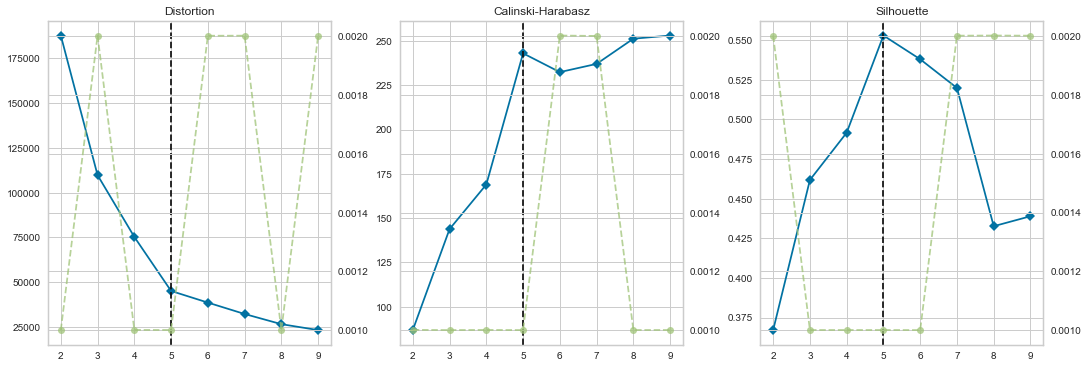

In [37]:
hierClust = AgglomerativeClustering(linkage='ward', n_clusters=2)
elbowPlot(custX, hierClust, (2,10))

For our hierarchy clustering the different metrics are in agreement: 5.

How about for our circular data:

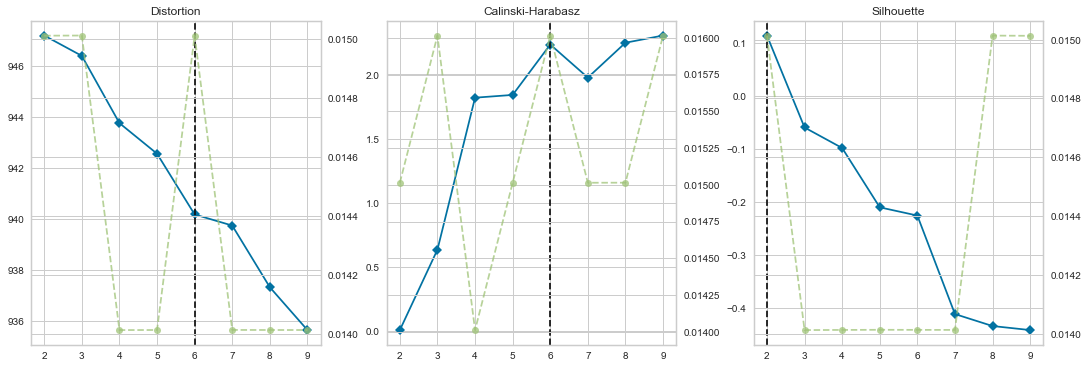

In [38]:
hierClust = AgglomerativeClustering(linkage='single', n_clusters=2)
elbowPlot(circX, hierClust, (2,10))

The distortion and Sihouette seem to agree on 2, and the Calinski-Harabasz sets it to 6.

Oh, almost forgot. How about those dendrograms. Unfortunately not in sklearn, but <a href="https://scipy.org/">*scipy*</a> has us covered with a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html">**dendrogram()**</a> function and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html">**linkage()**</a> function:

TypeError: float() argument must be a string or a number, not 'AgglomerativeClustering'

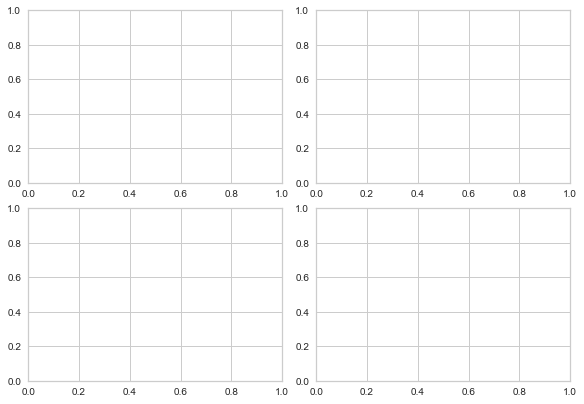

In [57]:
compareLinkage(np.asarray(hierClust), 6)


In [39]:
#!pip install scipy
from scipy.cluster.hierarchy import dendrogram, linkage

The parameters of interest for the **linkage** are:
* *y*: our data
* *method*: the linkage we want to use

After this we can use the result as the parameter for **dendrogram**.

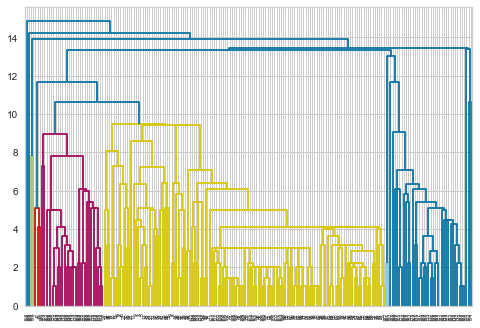

In [40]:
Z = linkage(custX, method='single')
dendrogram(Z)
plt.show()

We can zoom in by changing the *'truncate_mode'* parameter with a specific 'p' parameter:

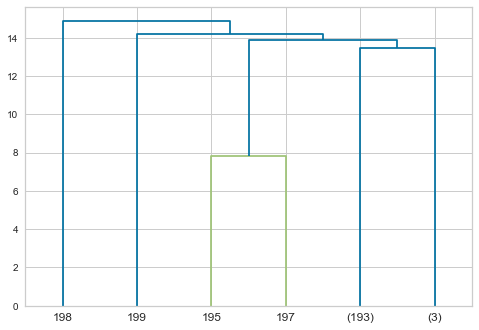

In [41]:
dendrogram(Z, p=3, truncate_mode='level')
plt.show()

The numbers at the bottom indicate the number of datapoints are in that cluster. For more info on dendrograms in general see: https://www.displayr.com/what-is-dendrogram.

Okay, so we have another technique but lets introduce a new situation...

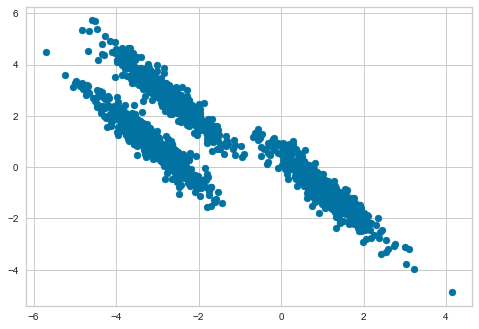

In [42]:
X, y = datasets.make_blobs(n_samples=1500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso = np.dot(X, transformation)
plt.scatter(aniso[:,0],aniso[:,1]);

There appear to be three clear clusters. Lets see how our hierarchical clustering performs on this...

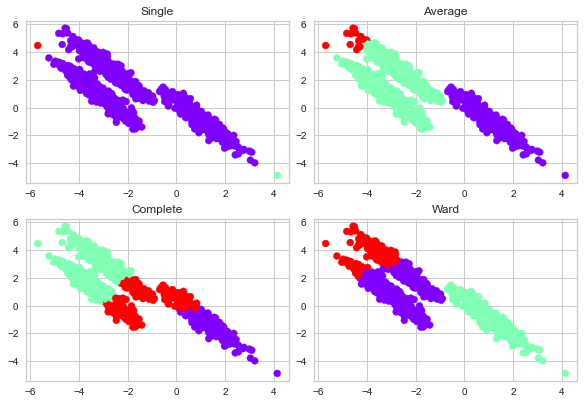

In [43]:
# from scipy.cluster.hierarchy import dendrogram, linkage
compareLinkage(aniso, 3)

Oh oh, none of them are any good :-(. We could try some other linkage technique (see Appendix A2 for Centroid and Median), but perhaps k-means works here?

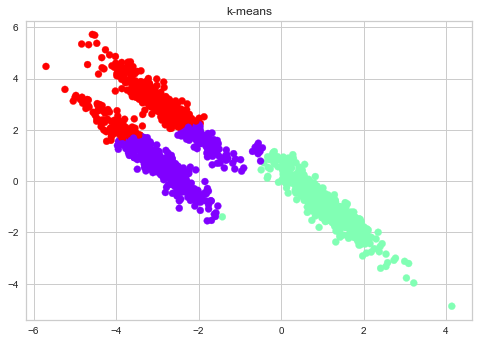

In [44]:
kmeans = KMeans(init='random', algorithm='full', n_clusters=3, random_state=0)
kmeans.fit(aniso)
plt.scatter(aniso[:,0],aniso[:,1], c=kmeans.labels_, cmap='rainbow')
plt.title('k-means')
plt.show()

Hmmm. None of the techniques so-far seem to be able to perform well. Hopefully the next technique can sort this out....

<font size="8"><center>Back to the slides</center></font>

## 6.3. DBSCAN

Also for DBSCAN the sklearn library has a nice function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">**DBSCAN()**</a>. 

In [45]:
from sklearn.cluster import DBSCAN

Lets see how the DBSCAN holds up...

As parameters we need to set it has:
* *eps*: the radius of neighborhood around a point x.
* *min_samples*: the minimum number of points that need to be in a cluster

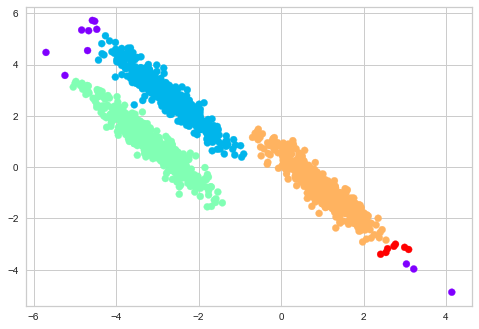

In [46]:
dbscan = DBSCAN(eps=0.3, min_samples=4)
dbscan.fit(aniso)
plt.scatter(aniso[:,0],aniso[:,1], c=dbscan.labels_, cmap='rainbow');

Not bad. 

One method to determine a good 'epsilon' is by looking at the number of neighbors for each point. This method is described relatively well on https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/ and a Python version of this was asked about on stackoverflow: https://stackoverflow.com/questions/48010276/how-to-estimate-eps-using-knn-distance-plot-in-dbscan/48594371#48594371

This method does require the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html">**NearestNeighbors()**</a> function.

In [47]:
from sklearn.neighbors import NearestNeighbors

The **NearestNeighbors** parameters of interest is only one:
* *n_neighbors*: the number minimum number of neighbors

Below is the code to create a diagram with hopefully an elbow in it:

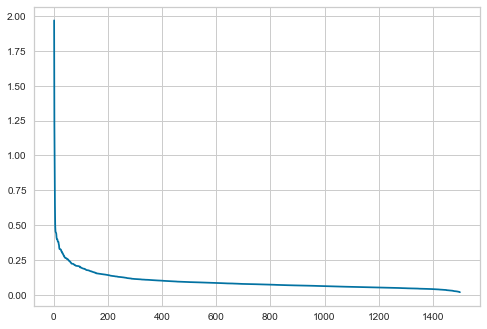

In [48]:
ns=4 # the minimum number of neighbors
nbrs = NearestNeighbors(n_neighbors=ns).fit(aniso)
distances, indices = nbrs.kneighbors(aniso)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(list(range(1,aniso.shape[0]+1)), distanceDec);

The elbow seems to occur around 0.3, which is why I used it.

Lets see how well this DBSCAN works with our other data sets:

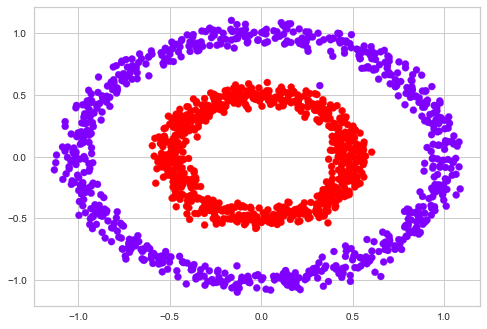

In [49]:
dbscan = DBSCAN(eps=0.1,min_samples=30)
dbscan.fit(circX)
plt.scatter(circX[:,0],circX[:,1], c=dbscan.labels_, cmap='rainbow');

And our customer data...

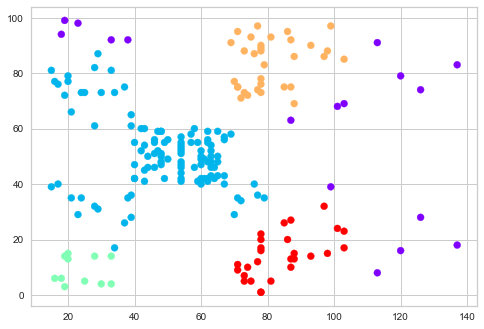

In [50]:
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan.fit(custX)
plt.scatter(custX.iloc[:,0],custX.iloc[:,1], c=dbscan.labels_, cmap='rainbow');

Perhaps first normalize the data. We can use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">**StandardScaler()**</a> again (we've seen this already in the previous two sessions) for this. 

In [51]:
from sklearn.preprocessing import StandardScaler

In Appendix A4 there is also some details, as well as another type of scaler that might be useful in some cases.

Now apply this:

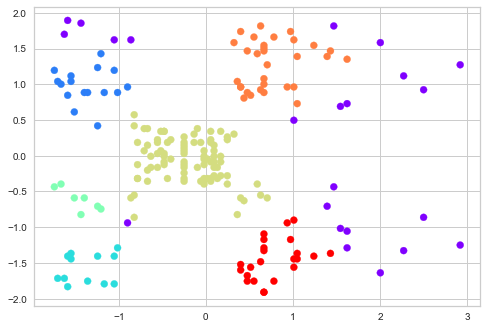

In [52]:
# set the scaler
scaler = StandardScaler()
scaler.fit(custX)

# Convert the train and test X values, using the same scaler (so based on the X_train)
custXsc = scaler.transform(custX)

dbscan = DBSCAN(eps=0.35, min_samples=5)
dbscan.fit(custXsc)
plt.scatter(custXsc[:,0],custXsc[:,1], c=dbscan.labels_, cmap='rainbow');

Better, but DBSCAN has difficulties with clusters of different densities.

Another dataset where DBSCAN will not work very well

In [53]:
data = np.load('../data/clusterable_data.npy')

dbscan = DBSCAN(eps=0.05, min_samples=20)
dbscan.fit(data)
plt.scatter(data[:,0],data[:,1], c=dbscan.labels_, cmap='rainbow');

FileNotFoundError: [Errno 2] No such file or directory: '../data/clusterable_data.npy'

Hmmm. 

In appendix A3 you can see two other density based methods (Mean Shift and OPTICS), but they will also not work very well in this situation.

Well HDBSCAN to the rescue....

<font size="8"><center>Back to the slides</center></font>

## 6.4. HDBSCAN

This technique is relatively new (well, I'm writing this in 2020, and the paper on the HDBSCAN* is from 2017). It has not yet been implemented in sklearn, but there is a library of its own.

<a href="https://hdbscan.readthedocs.io/en/latest/">*hdbscan*</a> was difficult to install. I had to install the Desktop development with C++ in my Visual Studio. Then uninstalled numpy **using the CMD.exe prompt**, then installed in the prompt hdbscan.

In 2022 I fixed the issue by running *conda install -c conda-forge hdbscan*, again **using the CMD.exe prompt**.

After that we can load the package and then use it as before:

In [ ]:
import hdbscan

The library comes with a **HDBSCAN()** function that has as important parameters:
* *min_cluster_size*: the minimum number of points you want in a cluster
* *gen_min_span_tree*: boolean to indicate if you also want to see a minimum spanning tree

Lets see first how this performs on our customer data:

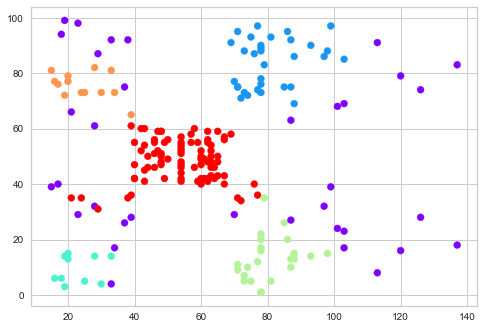

In [ ]:
hdbscanModel = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscanModel.fit(custX)
plt.scatter(custX.iloc[:,0],custX.iloc[:,1], c=hdbscanModel.labels_, cmap='rainbow');

Note that the purple dots are outliers, they are not assigned to any cluster.

We can get the minimum spanning tree, the dendrogram and condensed tree plot as well: 

In [ ]:
import seaborn as sns

def HDBSCANvisuals():
    # set the plotting stage for later
    plt.figure(figsize=(10,3))

    plt.subplot(131)
    plt.gca().set_title('Min. Spanning Tree')
    hdbscanModel.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80,edge_linewidth=2)

    plt.subplot(132)
    plt.gca().set_title('Dendrogram')
    hdbscanModel.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

    plt.subplot(133)
    plt.gca().set_title('Condensed Tree')
    hdbscanModel.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

    # Show the results
    plt.show()

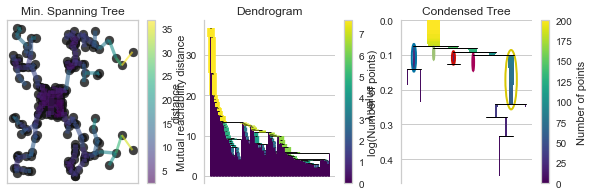

In [ ]:
HDBSCANvisuals()

Lets see how well this new technique solves the problem of our previous section:

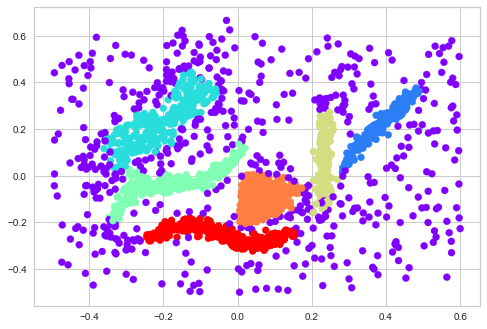

In [ ]:
hdbscanModel = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
hdbscanModel.fit(data)
plt.scatter(data[:,0],data[:,1], c=hdbscanModel.labels_, cmap='rainbow');

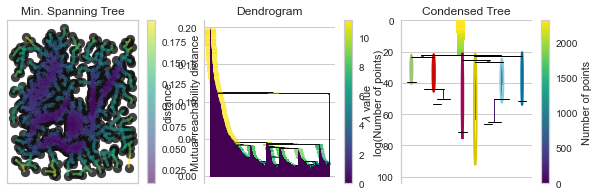

In [ ]:
HDBSCANvisuals()

What about our circles and aniso data?

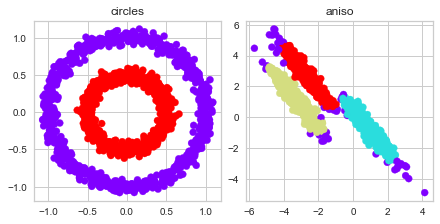

In [ ]:
fig, axs = plt.subplots(1,2, constrained_layout=True,figsize=(6,3))

hdbscanModel = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscanModel.fit(circX)
axs[0].scatter(circX[:,0],circX[:,1], c=hdbscanModel.labels_, cmap='rainbow')
axs[0].set_title('circles')

hdbscanModel = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
hdbscanModel.fit(aniso)
axs[1].scatter(aniso[:,0],aniso[:,1], c=hdbscanModel.labels_, cmap='rainbow')
axs[1].set_title('aniso')

plt.show();

It appears that HDBSCAN* works with whatever we throw at it. Is it therefor always the best technique to use, and why bother with all the other ones then? Well......

<font size="8"><center>Back to the slides</center></font>

# Appendix

## A1: Some Other Centroid Methods
In this appendix the python codes on how to run Affinity Propagation, Spectral Clustering, Mini Batch K-means, and k-Medoids is shown. 

The data used is the customer data:

In [ ]:
# load data as panda data frame
custdf = pd.read_csv('data/Mall_Customers.csv')
# rename some of the longer field names
custdf=custdf.rename(columns={"Annual Income (k$)":"income", "Spending Score (1-100)":"spendingScore"})
# Set the two variables as X
X =custdf[["income", "spendingScore"]]
# Remove missing values
X=custX.dropna()

**Affinity Propagation**

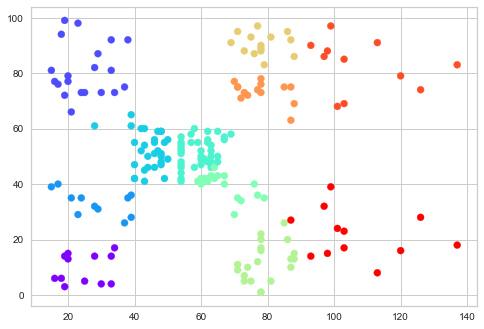

In [ ]:
# Load the library
from sklearn.cluster import AffinityPropagation

# Set and run the model
apc = AffinityPropagation()
apc.fit(X)

# Plot results
plt.scatter(X.iloc[:,0],X.iloc[:,1], c=apc.labels_, cmap='rainbow');

**Spectral Clustering**

C:\Users\peter.stikker\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  est = KMeans(


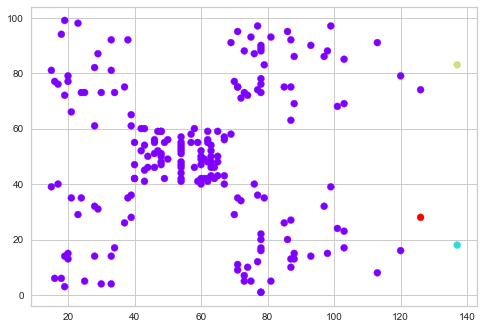

In [ ]:
# Load the library
from sklearn.cluster import SpectralClustering

# Set and run the model
spectral = SpectralClustering(n_clusters=5)
spectral.fit(X)

# Plot results
plt.scatter(X.iloc[:,0],X.iloc[:,1], c=spectral.labels_, cmap='rainbow');

**Mini Batch k-Means**

C:\Users\peter.stikker\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


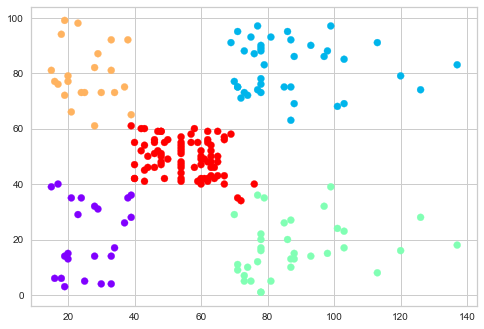

In [ ]:
# Load the library
from sklearn.cluster import MiniBatchKMeans

# Set and run the model
miniBatch = MiniBatchKMeans(n_clusters=5, random_state=0, batch_size=6)
miniBatch.fit(X)

# Plot results
plt.scatter(X.iloc[:,0],X.iloc[:,1], c=miniBatch.labels_, cmap='rainbow');

Note that we get a warning message again. You can use the same code and adapt it to ignore this in the future, as we did at the beginning. 

**k-Medoids**

C:\Users\PETER~1.STI\AppData\Local\Temp/ipykernel_21340/2493141507.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Xarr=np.array(clusters)


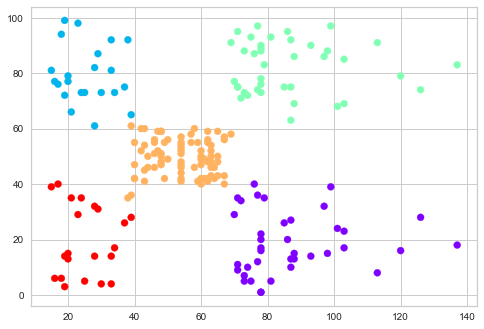

In [ ]:
# Load the library kmedoids
from pyclustering.cluster.kmedoids import kmedoids

# This requires the data to be a list (not a data frame)
Xlist=X.values.tolist()

# set and initialize the model. Requires k initializiation points
kmedoids_instance=kmedoids(Xlist, [1,5,8,10,12])
kmedoids_instance.process()

# The clusters can be obtained using
clusters = kmedoids_instance.get_clusters()

#Convert the clusters from a list to an array
Xarr=np.array(clusters)

# Create the re-coding
# The clusters are lists each with the datapoints, we want them to be in 0 to k format
labels=np.empty(200)
for i in Xarr[0]:
    labels[i] = 0
for i in Xarr[1]:
    labels[i] = 1
for i in Xarr[2]:
    labels[i] = 2
for i in Xarr[3]:
    labels[i] = 3
for i in Xarr[4]:
    labels[i] = 4

# now we can plot them
plt.scatter(X.iloc[:,0],X.iloc[:,1], c=labels, cmap='rainbow');

Another warning, but this is quite different from the previous ones. It can easily be dealt with if we just do as it recommends us to do: add the 'dtype=object' when creating the array. So if you change the line of code above.

From:
Xarr=np.array(clusters)

To:
Xarr=np.array(clusters, dtype=object)

The warning will disappear.

## A2: Centroid and Median Linkage

sklearn only seems to have single, average, complete and ward linkage. However in the linkage from scipy we also find centroid and median. We'll need fcluster then to actually convert these so we can get the labels out and plot the result.

In [ ]:
from scipy.cluster.hierarchy import fcluster

**Centroid linkage**

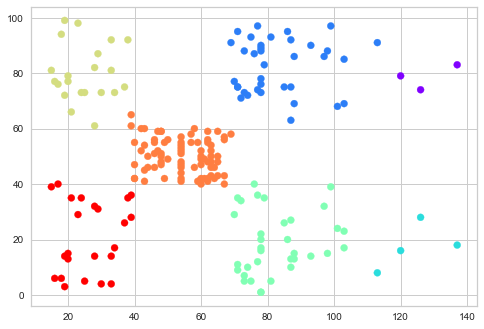

In [ ]:
# Set the model
centroid = linkage(custX, method='centroid')

# Get the labels for the clusters
labels = fcluster(centroid, t=25, criterion='distance') 

# Plot the result
plt.scatter(custX.iloc[:,0],custX.iloc[:,1], c=labels, cmap='rainbow');

**Median Linkage**

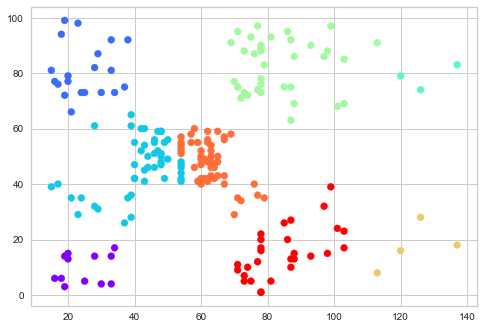

In [ ]:
# Set the model
median = linkage(custX, method='median')

# Get the labels for the clusters
labels = fcluster(median, t=25, criterion='distance')

# Plot the result
plt.scatter(custX.iloc[:,0],custX.iloc[:,1], c=labels, cmap='rainbow');

## A3: Mean Shift and OPTICS

**Mean Shift**

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(data)

0.2979378165538261

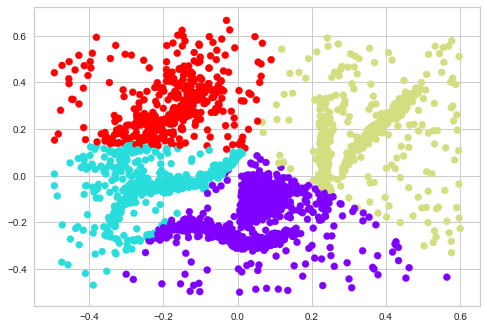

In [ ]:
meanShift = MeanShift(bandwidth=0.2)
meanShift.fit(data)
plt.scatter(data[:,0],data[:,1], c=meanShift.labels_, cmap='rainbow');

**OPTICS**

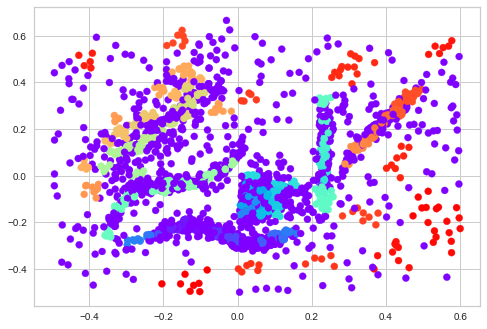

In [ ]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=5)
optics.fit(data)
plt.scatter(data[:,0],data[:,1], c=optics.labels_, cmap='rainbow');

## A4 Standard Scaler and MinMax Scaler

**Standard Scaler**

The 'StandardScaler' was used in this Notebook. What this does, it transforms each column to normalized scores. Normalized means in general to subtract the mean, and then divide by the standard deviation. The standard deviation is a measure of variation and was discussed in the Statistics lecture. In formula notation:

\begin{equation*}
Z = \frac{x - \bar{x}}{\sigma}
\end{equation*}

The $\bar{x}$ is the mean of field X, and $\sigma$ is the population standard deviation (the sample standard deviation to be a bit more precise)

What this does, is that each normalized score shows how many standard deviations that data point was from the mean. So if a datapoint has a z-score of 2.5 it means that it 2.5 times the standard deviation above the mean. If the mean is 4 and the standard deviation is 2. A z-score of 2.5 means that the actual score was 4 + 2.5*2 = 9. In reverse the z-score is (9-4)/2 = 2.5.

A high z-score (positive or negative) indicates the datapoint was far from the center.

Note that sklearn has a 'StandardScaler' but also a 'Normalizer'. The difference is that the 'StandardScaler' operates over the columns (fields), while 'Normalizer' does the same but for each row (record). We usually want the StandardScaler.

Below an example:

In [ ]:
myExample=np.array([5,8,10,12,50]).reshape(-1, 1)

(myExample - myExample.mean()) / myExample.std()

array([[-0.72023051],
       [-0.54017288],
       [-0.42013446],
       [-0.30009605],
       [ 1.9806339 ]])

And with sklearn:

In [ ]:
# Import the standardscaler package
from sklearn.preprocessing import StandardScaler

# set the scaler
scaler = StandardScaler()
scaler.fit(myExample)

# transform
scaler.transform(myExample)

array([[-0.72023051],
       [-0.54017288],
       [-0.42013446],
       [-0.30009605],
       [ 1.9806339 ]])

**Min Max Scaler**

The range of z-scores is usually not so different between two fields. But there is no limit. A z-score of 10000000000 is possible. Another method to scale the data, is by the MinMaxScaler.

This sets the minimum value to 0, the maximum value to 1, and all other values relatively between 0 and 1 using:

\begin{equation*}
m = \frac{x - min}{max - min}
\end{equation*}

For example. If we have [5, 8, 10, 12, 50], then we set 5 to 0 and 50 to 1. For 8 we now use (8 - 5)/(50-5) = 0.0667.

Below some example code:

In [ ]:
myExample=np.array([5,8,10,12,50]).reshape(-1, 1)

(myExample - myExample.min()) / (myExample.max() - myExample.min())

array([[0.        ],
       [0.06666667],
       [0.11111111],
       [0.15555556],
       [1.        ]])

And with sklearn...

In [ ]:
from sklearn.preprocessing import MinMaxScaler

myExample=np.array([5,8,10,12,50]).reshape(-1, 1)

# set the scaler
scaler = MinMaxScaler() 
scaler.fit(myExample)

# transform
scaler.transform(myExample)

array([[0.        ],
       [0.06666667],
       [0.11111111],
       [0.15555556],
       [1.        ]])